In [1]:
import pandana as pdna
import pandas as pd
import geopandas as gpd

import matplotlib
from matplotlib import pyplot as plt

Before running this notebook, first create the combined transit network using the notebook create_access_network.ipynb

# Create the Pandana network

In [2]:
nodes=pd.read_csv('./outputs/networks/nodes.csv', index_col=0)
edges=pd.read_csv('./outputs/networks/edges.csv', index_col=0)

In [3]:
transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_int"],
                               edges["to_int"],
                               edges[["weight"]], 
                               twoway=False)

# Get the POI Data

## Get Lat and Long from Addresses


In [4]:
from geopy.geocoders import Nominatim
# can be improved, as the latitude and longitude do not consider the address number
geolocator = Nominatim(user_agent="CS-Rome")

def extract_lat_long_from_address(df, address_col, address_suffix):
    df['latitude'] = ""
    df['longitude'] = ""
    for index,row in df.iterrows():
        address = row[address_col]
        try:
            location = geolocator.geocode(address + address_suffix)
            df.loc[index,['latitude']] = location.latitude
            df.loc[index,['longitude']] = location.longitude
        except:
            print('Error while managing address: ', address)

## Accomodations

In [5]:
ACCOMODATION_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/d51c988e-3e09-4175-9f6f-d3d61599417d/resource/d711888d-c4fb-4988-9a21-7783d65425c5/download/suar2021-08.csv'

In [6]:
accommodation=pd.read_csv(ACCOMODATION_DATA_LOC, sep=';')

In [7]:
accommodation.head()

,id,tipologia,denominazione,via,civico,latitude,longitude,stelle,categoria,totalePostiLetto,...,spaccio,campiBocce,campoBeachVolley,campoCalcetto,campoPallavolo,attraccoNatanti,numeroBungalow,numeroDocce,numeroLavadini,numeroPiazzole
0,338189,Guest House o Affittacamere,00146 ROMA HOLIDAY AND JUBILEE HOUSE,Via Efeso,19,41.854266,12.474979,NaN,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,336739,Guest House o Affittacamere,126 GRACCHI SUITES GUEST HOUSE O AFFITTACAMERE,Via dei Gracchi,126,41.908495,12.463876,NaN,2.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335666,Guest House o Affittacamere,149 GUEST HOUSE,Via Marmorata,149,41.881459,12.476980,NaN,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,336886,Guest House o Affittacamere,1880 ATYPICAL ROOMS,Via Nazionale,66,41.899339,12.491388,NaN,2.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,337239,Guest House o Affittacamere,19 STEPS TREVI GUEST HOUSE O AFFITTACAMERE,Via dei Crociferi,26,41.900808,12.481812,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
accommodation.groupby('tipologia').size()

tipologia
Agriturismi                          23
Alberghi                            883
Alloggi per uso turistico          8332
Bed and Breakfast                  1413
Campeggi                             17
Case e appartamenti per vacanze    5418
Case per ferie                      246
Dipendenze alberghiere               67
Guest House o Affittacamere        2993
Ostelli per la gioventù              20
Residence                            33
dtype: int64

Remove entries with invalid lat and lon to avoid errors in pandana analysis

In [9]:
print(len(accommodation))
accommodation=accommodation.loc[
    ((~accommodation['longitude'].isnull())&
     (~accommodation['latitude'].isnull()))
]
print(len(accommodation))

19445
19411


<AxesSubplot:>

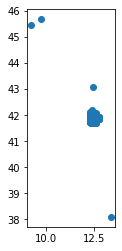

In [10]:
accommodation_gdf=gpd.GeoDataFrame(data=accommodation,geometry=gpd.points_from_xy(
    x=accommodation.longitude, 
    y=accommodation.latitude, 
    crs='EPSG:4326'))
accommodation_gdf.plot()

In [11]:
accommodation_gdf.to_file('./outputs/accomodation.geojson', 
                          driver='GeoJSON')

## Public transport stops

In [12]:
TRANSPORT_STOPS_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/a7dadb4a-66ae-4eff-8ded-a102064702ba/resource/266d82e1-ba53-4510-8a81-370880c4678f/download/rome_static_gtfs_test.zip'

In [13]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen(TRANSPORT_STOPS_DATA_LOC)
zipfile = ZipFile(BytesIO(resp.read()))

In [14]:
transport_stops=pd.read_csv(zipfile.open('stops.txt'), sep=',')
transport_stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,stop_url,wheelchair_boarding,stop_timezone,location_type,parent_station
0,73620,73620,ARDEATINA/FOSSO CECCHIGNOLA,NaN,41.814308,12.523443,NaN,NaN,NaN,NaN,NaN
1,73673,73673,ARDEATINA/MILLEVOI,NaN,41.817655,12.522370,NaN,NaN,NaN,NaN,NaN
2,78440,78440,ARMANDI/DRAGONCELLO,NaN,41.784225,12.350002,NaN,NaN,NaN,NaN,NaN
3,78745,78745,ASCARI/NUVOLARI,NaN,41.834925,12.502812,NaN,NaN,NaN,NaN,NaN
4,77967,77967,ASPERTINI/GABBIANI,NaN,41.872222,12.629692,NaN,NaN,NaN,NaN,NaN


## Municipal Sport Centers

In [15]:
SPORTS_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/acb9bbf0-9beb-409d-b5e8-b4407dec1aef/resource/809dfc0d-f305-4b9e-a487-2b4ce7fd5b0c/download/centri_sportivi_municipali_2018.csv'

In [16]:
sports_centers=pd.read_csv(SPORTS_DATA_LOC, sep=';',encoding = "latin")

In [17]:
sports_centers

,ID,MUNICIPIO,ISTITUTO COMPRENSIVO,CENTRO SPORTIVO MUNICIPALE,INDIRIZZO,LARGHEZZA,LUNGHEZZA,ALTEZZA,SPOGLIATOI,STATO MANUTENTIVO,NOTE
0,1,I,I.C. Via delle Carine,Plesso Mazzini,"Via delle Carine, 2",9,"14,2",5,si,discreto,NaN
1,2,I,I.C. Regina Elena,Plesso R. Elena,"Via Puglie, 6",9,18,6,si,discreto,NaN
2,3,I,I.C. Regina Elena,Plesso Pestalozzi,"Via Montebello, 118","9,5","10,5",6,no,mediocre,NaN
3,4,I,I.C. Virgilio,Plesso Cadlolo,"Via della Rondinella, 2",9,20,7,no,discreto,NaN
4,5,I,I.C. Dante Alighieri,Plesso Cassiodoro,"Via Cassiodoro, 2B",12,"23,7",7,si,ottimo,NaN
...,...,...,...,...,...,...,...,...,...,...,...
357,358,XV,NaN,Enzo Biagi - Angelini - M. Periello,"Via Quero, 130","10,5","20,7",NaN,si,buono,NaN
358,359,XV,NaN,Karol Wojtyla - Sede centrale,"Via Concesio, 2","11,5","23,85",6,si,discreto,NaN
359,360,XV,NaN,Karol Wojtyla - Plesso,"Largo Giampaolo Borghi, 6","12,3","24,55",NaN,si,discreto,NaN
360,361,XV,NaN,Parco di Veio - Sede Centrale,Via Fosso del Fontaniletto,"11,1","22,45",6,si,buono,NaN


In [18]:
sports_centers["INDIRIZZO"]=sports_centers["INDIRIZZO"].apply(str)
# Fixing addresses withouth address number
for index,row in sports_centers.iterrows():
    if ', SNC' in row['INDIRIZZO']:
        sports_centers.loc[index,['INDIRIZZO']] = row['INDIRIZZO'].replace(', SNC', ', 1')

In [19]:
extract_lat_long_from_address(sports_centers, address_col="INDIRIZZO", address_suffix=", Roma, Roma Capitale, Lazio, Italia")

Error while managing address:  P.le deglie Eroi, 14
Error while managing address:  Via S.M. Goretti, 43
Error while managing address:  Piazza Ruggero da Sicilia, 2
Error while managing address:  Via R. Calabria, 48
Error while managing address:  Via G. da Procida, 16 
Error while managing address:  Via G. da Procida, 16 
Error while managing address:  Via J. Pintor, 6
Error while managing address:  Via Don G. M. Mussolillo, 64
Error while managing address:  Via F. andò, 15
Error while managing address:  Via Antonio Serassi,75
Error while managing address:  Via V. mezzogiorno, 20
Error while managing address:  Via Scalo di Settebagni, 45
Error while managing address:  Via Scalo di Settebagni, 45
Error while managing address:  Via G. De Santis, 27
Error while managing address:  Via C. Angiolieri, 15
Error while managing address:  Via Saffiano, 34
Error while managing address:  Via M. Baldo, 2
Error while managing address:  Via Casal Bianco, 140
Error while managing address:  Via N.M. Nic

In [20]:
#removing rows withouth coordinates
sports_centers.replace("", float("NaN"), inplace=True)
sports_centers["latitude"]=sports_centers["latitude"].apply(float)
sports_centers["longitude"]=sports_centers["longitude"].apply(float)
sports_centers.dropna(subset = ["latitude", "longitude"], inplace=True)

In [21]:
sports_centers

,ID,MUNICIPIO,ISTITUTO COMPRENSIVO,CENTRO SPORTIVO MUNICIPALE,INDIRIZZO,LARGHEZZA,LUNGHEZZA,ALTEZZA,SPOGLIATOI,STATO MANUTENTIVO,NOTE,latitude,longitude
0,1,I,I.C. Via delle Carine,Plesso Mazzini,"Via delle Carine, 2",9,"14,2",5,si,discreto,NaN,41.892553,12.490998
1,2,I,I.C. Regina Elena,Plesso R. Elena,"Via Puglie, 6",9,18,6,si,discreto,NaN,41.910432,12.495173
2,3,I,I.C. Regina Elena,Plesso Pestalozzi,"Via Montebello, 118","9,5","10,5",6,no,mediocre,NaN,41.906285,12.501176
3,4,I,I.C. Virgilio,Plesso Cadlolo,"Via della Rondinella, 2",9,20,7,no,discreto,NaN,41.901138,12.468548
4,5,I,I.C. Dante Alighieri,Plesso Cassiodoro,"Via Cassiodoro, 2B",12,"23,7",7,si,ottimo,NaN,41.906183,12.465886
...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,358,XV,NaN,Enzo Biagi - Angelini - M. Periello,"Via Quero, 130","10,5","20,7",NaN,si,buono,NaN,42.040546,12.306673
358,359,XV,NaN,Karol Wojtyla - Sede centrale,"Via Concesio, 2","11,5","23,85",6,si,discreto,NaN,42.003132,12.485830
359,360,XV,NaN,Karol Wojtyla - Plesso,"Largo Giampaolo Borghi, 6","12,3","24,55",NaN,si,discreto,NaN,42.008192,12.479552
360,361,XV,NaN,Parco di Veio - Sede Centrale,Via Fosso del Fontaniletto,"11,1","22,45",6,si,buono,NaN,41.973973,12.438325


In [23]:
sports_centers.groupby('MUNICIPIO').size()

MUNICIPIO
I       11
II      10
III     25
IV      13
IX       3
V       28
VI      39
VIII    11
XI      10
XII     11
XIII    14
XIV     17
XV      26
dtype: int64

In [24]:
sports_centers.groupby('STATO MANUTENTIVO').size()

STATO MANUTENTIVO
buone                                            1
buono                                           46
buonoo                                           1
cattivo                                          4
discreto                                        28
idoneo all'affidamento                          25
idoneo per attività sportive                    38
inagibile per lavori in corso alle strutture     1
mediocre                                        17
necessita manutenzione                           1
necessità interventi                             1
ottimo                                           3
palestra in ristrutturazione                     1
pavimentazione necessità manutenzione            1
pessimo                                          2
pessimo, non agibile                             1
sufficiente                                      2
dtype: int64

# Public Libraries

In [25]:
LIBS_LOC='dataset/DATI_BIBLIOTECHE_EXCEL_01.xls'

In [26]:
libs = pd.read_excel(LIBS_LOC, sheet_name='Report personalizzato')  
libs.head()

,biblioteca,codice biblioteca,sigla provincia,provincia,CAP,città,indirizzo,cod. paese,paese,email,telefono
0,B. COSTANZO LICEO GIULIO CESARE,RMBWG,RM,ROMA,198.0,ROMA,Corso Trieste 48,IT,ITALIA,NaN,NaN
1,BIBLIOBUS,RMBX1,NaN,NaN,NaN,ROMA,.,IT,ITALIA,ill.bibliobus@bibliotechediroma.it,NaN
2,BIBLIOCAFFE' LETTERARIO,RMBM1,RM,ROMA,NaN,ROMA,VIA OSTIENSE 95,IT,ITALIA,ill.bibliocaffe@bibliotechediroma.it,0645460710
3,BIBLIOTECA ALDO FABRIZI,RMBE2,RM,ROMA,156.0,ROMA,Via Treia 14,IT,ITALIA,ill.aldofabrizi@bibliotechediroma.it,0645460730
4,BIBLIOTECA ARGENTINA,RMBWC,RM,ROMA,187.0,ROMA,"Via Vittorio Veneto, 7 - 2° piano",IT,ITALIA,biblioteca@ambasciatargentina.it,064873866


In [27]:
extract_lat_long_from_address(libs, address_col="indirizzo", address_suffix=", Roma, Italia")

Error while managing address:  Via Vittorio Veneto, 7  -  2° piano
Error while managing address:  VIA LIBERO LEONARDO 153
Error while managing address:  VIA SAN PAOLO ALLA REGOLA, 16
Error while managing address:  VIA COLLI PORTUENSI, 275
Error while managing address:  via delle Galline Bianche
Error while managing address:  VIA LONGHENA 98
Error while managing address:  via Penazzato, 112
Error while managing address:  Viale Caduti per la Resistenza 410/A
Error while managing address:  Via M. Mazzacurati 76
Error while managing address:  LARGO III GIUGNO 1849 SNC
Error while managing address:  Via Bompietro SNC
Error while managing address:  Magazzino centrale
Error while managing address:  PALAZZO ESPOSIZIONI - VIA NAZIONALE 194


In [28]:
#removing rows withouth coordinates
libs.replace("", float("NaN"), inplace=True)
libs["latitude"]=libs["latitude"].apply(float)
libs["longitude"]=libs["longitude"].apply(float)
libs.dropna(subset = ["latitude", "longitude"], inplace=True)

## Primary Schools

In [29]:
SCHOOLS_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/752549b2-a55b-4de1-acb0-e638876c0fb1/resource/e31f7557-1659-46eb-b2a6-0f908a6a7d33/download/02-infanzia_09-10.csv'

In [30]:
schools=pd.read_csv(SCHOOLS_DATA_LOC, sep=';',encoding = "latin")
schools = schools.dropna()

In [31]:
schools.head()

,Municipio,Codice scuola,Nome scuola,Indirizzo,Telefono,Orario entrata/uscita,Corsi attivi,Totale capienza,Totale iscritti,Iscritti maschi,Iscritti femmine,Iscritti italiani,Iscritti non italiani
0,I,3557.0,A. BACCARINI,"Via Sforza, 2",06/4883788,08:00 / 17:00,3.0,75.0,65.0,35.0,30.0,58.0,7.0
1,I,3549.0,A. CADLOLO,"Via Della Rondinella, 2",06/68802521,08:00 / 17:00,4.0,100.0,93.0,48.0,45.0,87.0,6.0
2,I,2886.0,ADELAIDE CAIROLI,"Via Giordano Bruno, 2",06/39738646,08:00 / 17:00,9.0,217.0,207.0,93.0,114.0,171.0,36.0
3,I,3553.0,E.GIANTURCO,"Via Della Palombella, 4",06/68307753,08:00 / 17:00,3.0,63.0,55.0,32.0,23.0,53.0,2.0
4,I,3556.0,E.PESTALOZZI,"Via Mentana, 1",06/4941465,08:00 / 17:00,2.0,50.0,36.0,18.0,18.0,30.0,6.0


In [32]:
schools.groupby('Municipio').size()

Municipio
I       22
II      15
III     13
IV      26
IX      26
V       19
VI      13
VII     32
VIII    18
X       10
XI      16
XII     11
XIII    17
XIV     14
XV      15
dtype: int64

In [33]:
# Fixing addresses withouth address number
for index,row in schools.iterrows():
    if ', SNC' in row['Indirizzo']:
        schools.loc[index,['Indirizzo']] = row['Indirizzo'].replace(', SNC', ', 1')

In [34]:
extract_lat_long_from_address(schools, address_col="Indirizzo", address_suffix=", Roma, Italia")

In [35]:
schools.head()

,Municipio,Codice scuola,Nome scuola,Indirizzo,Telefono,Orario entrata/uscita,Corsi attivi,Totale capienza,Totale iscritti,Iscritti maschi,Iscritti femmine,Iscritti italiani,Iscritti non italiani,latitude,longitude
0,I,3557.0,A. BACCARINI,"Via Sforza, 2",06/4883788,08:00 / 17:00,3.0,75.0,65.0,35.0,30.0,58.0,7.0,41.8957,12.4953
1,I,3549.0,A. CADLOLO,"Via Della Rondinella, 2",06/68802521,08:00 / 17:00,4.0,100.0,93.0,48.0,45.0,87.0,6.0,41.9011,12.4685
2,I,2886.0,ADELAIDE CAIROLI,"Via Giordano Bruno, 2",06/39738646,08:00 / 17:00,9.0,217.0,207.0,93.0,114.0,171.0,36.0,41.357,13.4217
3,I,3553.0,E.GIANTURCO,"Via Della Palombella, 4",06/68307753,08:00 / 17:00,3.0,63.0,55.0,32.0,23.0,53.0,2.0,41.8982,12.4765
4,I,3556.0,E.PESTALOZZI,"Via Mentana, 1",06/4941465,08:00 / 17:00,2.0,50.0,36.0,18.0,18.0,30.0,6.0,41.9076,12.5029


## Run accessibility calculations

In [36]:
max_minutes=15

In [37]:
def access_analysis(network, df, lat_col_name, lon_col_name, name ):
    
    nodes = network.get_node_ids(df[lon_col_name], 
                                   df[lat_col_name])
    network.set(nodes, 
                name = name)
    access = network.aggregate(distance = max_minutes,
                                      type = 'count',
                                      name = name)
    print(access.describe())
    
    
    fig, ax = plt.subplots(figsize=(10,8))

    plt.title('Rome:' +name+ ' within 15 minutes transit/walking')
    plt.scatter(network.nodes_df.x, network.nodes_df.y, 
                c=access, s=1, cmap='YlOrRd', 
                norm=matplotlib.colors.LogNorm())
    cb = plt.colorbar()

    plt.show()
    
    nodes_gdf=gpd.GeoDataFrame(data={name+'_access': access,
                                'x':network.nodes_df.x,
                                'y':network.nodes_df.y},
                           geometry=gpd.points_from_xy(
                               x=network.nodes_df.x, 
                               y=network.nodes_df.y, 
                               crs='EPSG:4326'))
    nodes_gdf.to_file('./outputs/access/'+name+'_access.geojson', 
                          driver='GeoJSON')

## Accomodations

count    83987.000000
mean       539.476264
std       1082.326411
min          0.000000
25%         12.000000
50%         64.000000
75%        368.000000
max       7515.000000
dtype: float64


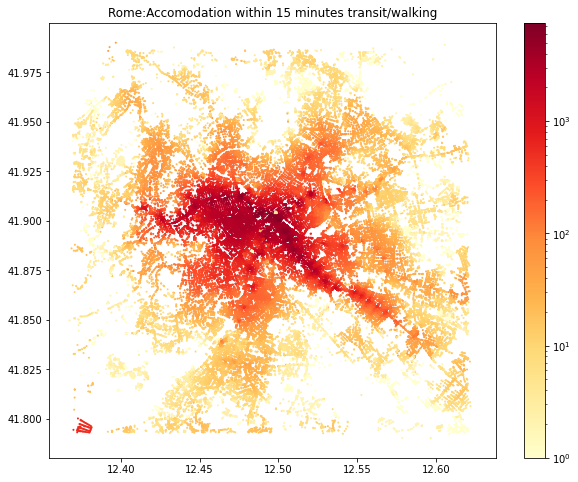

In [38]:
access_analysis(network=transit_ped_net, df=accommodation, lat_col_name='latitude', lon_col_name='longitude', name='Accomodation' )

## Primary Schools

count    83987.000000
mean         2.928036
std          2.719744
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
dtype: float64


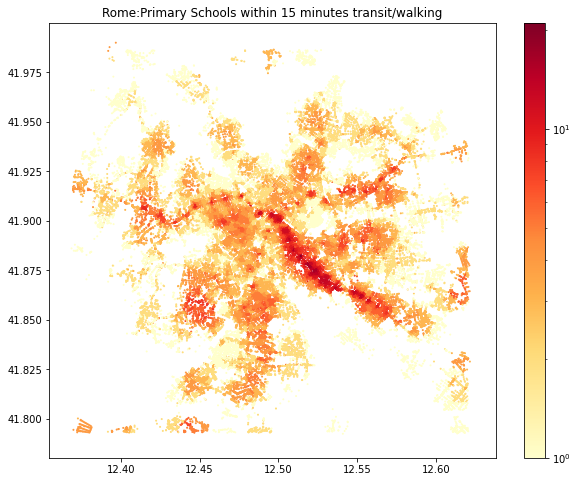

In [39]:
access_analysis(network=transit_ped_net, df=schools, lat_col_name='latitude', lon_col_name='longitude', name='Primary Schools' )

## Public Transport Stops

count    83987.000000
mean        86.040340
std         96.081097
min          0.000000
25%         27.000000
50%         57.000000
75%        100.000000
max        750.000000
dtype: float64


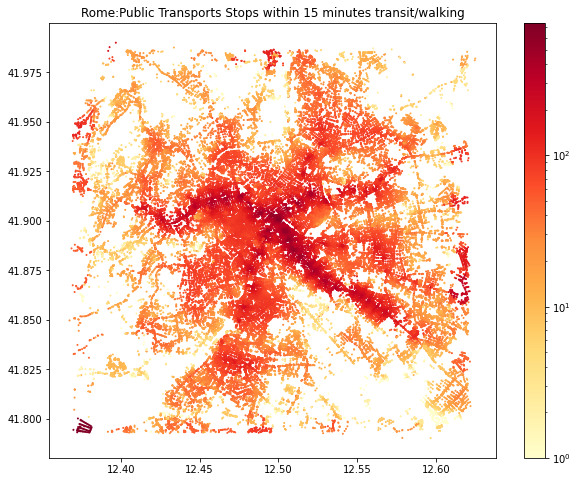

In [40]:
access_analysis(network=transit_ped_net, df=transport_stops, lat_col_name='stop_lat', lon_col_name='stop_lon', name='Public Transports Stops' )

## Public Libraries

count    83987.000000
mean         0.677843
std          1.133150
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          8.000000
dtype: float64


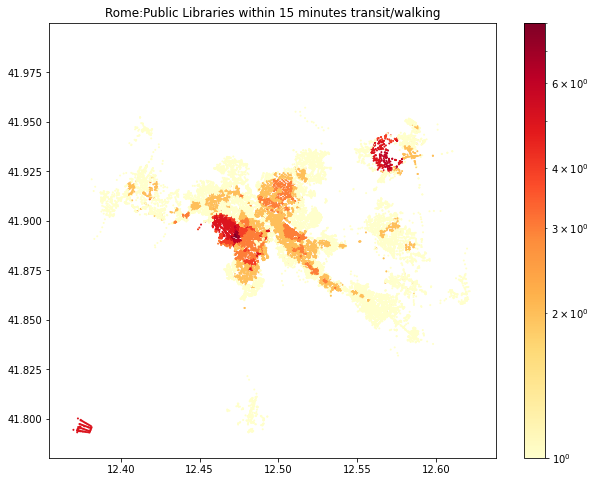

In [41]:
access_analysis(network=transit_ped_net, df=libs, lat_col_name='latitude', lon_col_name='longitude', name='Public Libraries' )

## Municipal Sports Centers

count    83987.000000
mean         1.539214
std          1.814826
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         25.000000
dtype: float64


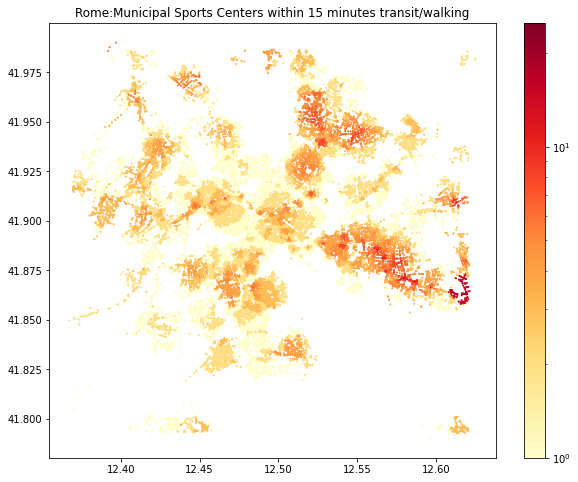

In [42]:
access_analysis(network=transit_ped_net, df=sports_centers, lat_col_name='latitude', lon_col_name='longitude', 
                name='Municipal Sports Centers' )